# Day 1: Capital Asset Pricing Model (CAPM)

---

### 🎯 Learning Objectives
- Understand the theoretical foundation of CAPM
- Calculate beta using regression analysis
- Interpret CAPM results for portfolio management
- Visualize the Security Market Line (SML)


---| α < 0 | Underperformed |

| α = 0 | Fair compensation for risk |

### 📈 Why CAPM Matters in Trading| α > 0 | Outperformed (skill or luck?) |

|-------|---------|

**CAPM is the foundation of ALL factor models.** It's Nobel Prize-winning work that every quant must know.| Alpha | Meaning |



### Key Formula**α = Actual Return - CAPM Expected Return**

$$E[R_i] = R_f + \beta_i(E[R_m] - R_f)$$

### Alpha: The Holy Grail

### Trading Applications

| β < 0 | Inverse to market | Gold, some hedges |

| Application | How CAPM Helps || β < 1 | Less volatile | Utilities, staples |

|-------------|---------------|| β = 1 | Moves with market | Index funds |

| **Risk Assessment** | Beta tells you market sensitivity || β > 1 | More volatile than market | Tech, small caps |

| **Expected Return** | Benchmark for fair return ||------|----------------|---------------|

| **Alpha Calculation** | Excess return = skill measure || Beta | Interpretation | Example Stocks |

| **Portfolio Construction** | Target specific beta exposure |

### Understanding Beta

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252  # Trading days per year
RISK_FREE_RATE = 0.05  # Risk-free rate (5%)

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. Calculate Beta Using Regression

| **t-stat** | Is the beta statistically significant? |

### 🎯 Two Methods to Calculate Beta| **R²** | How much is explained by market |

| **Alpha (α)** | Excess return (annualized) |

| Method | Formula | When to Use || **Beta (β)** | Market sensitivity |

|--------|---------|-------------||--------|-------------------|

| **Covariance** | Cov(Ri, Rm) / Var(Rm) | Quick calculation || Output | What It Tells You |

| **Regression** | OLS of Ri on Rm | Get alpha, R², t-stats |

### Trading Interpretation

In [2]:
# Use SPY as market proxy
market_returns = returns['AAPL']
daily_rf = RISK_FREE_RATE / TRADING_DAYS

def calculate_beta(stock_returns, market_returns):
    """Calculate beta using covariance method."""
    covariance = np.cov(stock_returns, market_returns)[0, 1]
    market_variance = np.var(market_returns)
    return covariance / market_variance

def calculate_beta_regression(stock_returns, market_returns):
    """Calculate beta using OLS regression."""
    excess_stock = stock_returns - daily_rf
    excess_market = market_returns - daily_rf
    
    X = sm.add_constant(excess_market)
    model = sm.OLS(excess_stock, X).fit()
    
    return model.params.iloc[1], model.params.iloc[0], model.rsquared

# Calculate betas for select stocks
test_stocks = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']

print("\n" + "="*60)
print("BETA CALCULATIONS")
print("="*60)
print(f"{'Stock':<8} {'Beta (Cov)':<12} {'Beta (OLS)':<12} {'Alpha':<12} {'R²':<8}")
print("-"*60)

beta_results = []
for stock in test_stocks:
    if stock in returns.columns:
        beta_cov = calculate_beta(returns[stock], market_returns)
        beta_ols, alpha, r2 = calculate_beta_regression(returns[stock], market_returns)
        
        beta_results.append({
            'stock': stock,
            'beta': beta_ols,
            'alpha': alpha * TRADING_DAYS,  # Annualized
            'r2': r2
        })
        
        print(f"{stock:<8} {beta_cov:<12.4f} {beta_ols:<12.4f} {alpha*TRADING_DAYS:<12.4%} {r2:<8.4f}")

beta_df = pd.DataFrame(beta_results)


BETA CALCULATIONS
Stock    Beta (Cov)   Beta (OLS)   Alpha        R²      
------------------------------------------------------------
AAPL     1.0008       1.0000       0.0000%      1.0000  
MSFT     0.5826       0.5821       6.3325%      0.3944  
GOOGL    0.6470       0.6465       18.2449%     0.3327  
JPM      0.3118       0.3115       13.8939%     0.1262  
GS       0.4025       0.4021       21.3398%     0.1665  


## 2. Security Market Line (SML)

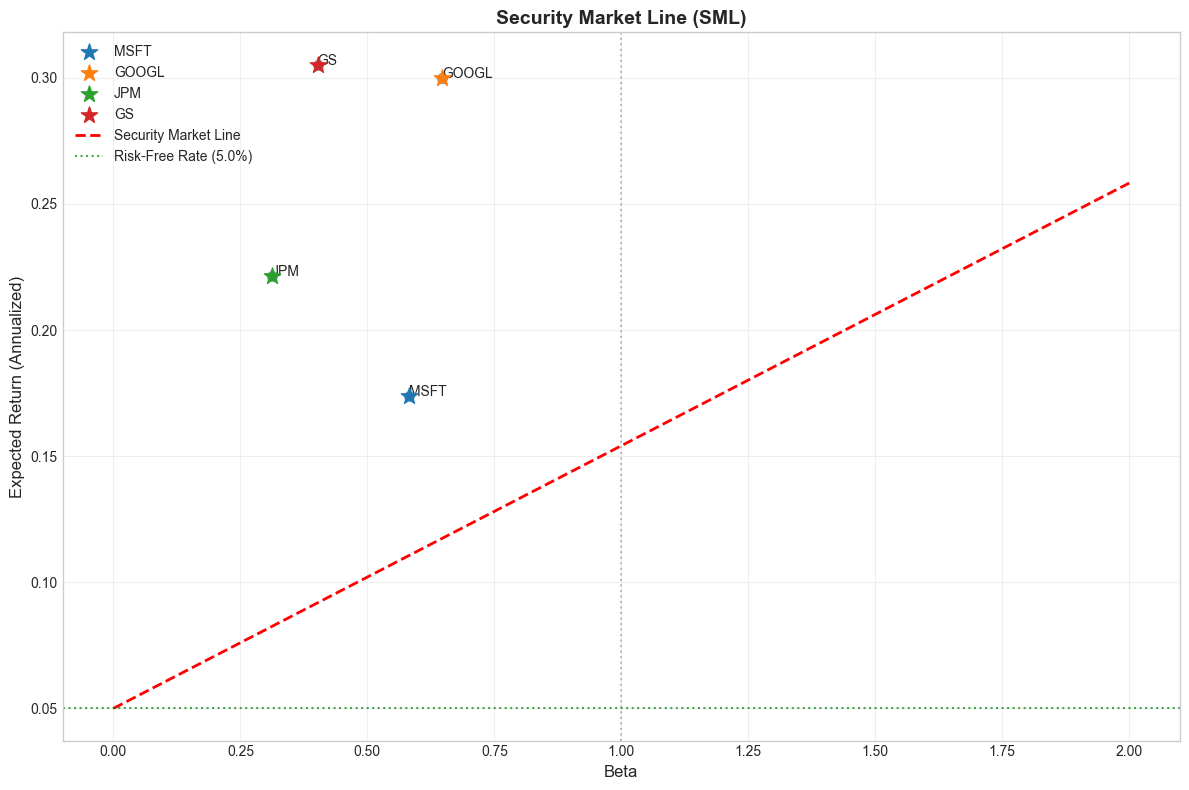


💡 Stocks ABOVE the SML have positive alpha (undervalued)
   Stocks BELOW the SML have negative alpha (overvalued)


In [3]:
# Calculate expected returns and betas for all stocks
all_betas = []
all_returns = []
all_stocks = []

for stock in returns.columns:
    if stock != 'AAPL':
        try:
            beta, alpha, r2 = calculate_beta_regression(returns[stock], market_returns)
            annual_return = returns[stock].mean() * TRADING_DAYS
            
            all_betas.append(beta)
            all_returns.append(annual_return)
            all_stocks.append(stock)
        except:
            pass

# Plot SML
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of all stocks
ax.scatter(all_betas, all_returns, alpha=0.6, s=50, c='steelblue')

# Highlight test stocks
for stock in test_stocks:
    if stock in all_stocks:
        idx = all_stocks.index(stock)
        ax.scatter(all_betas[idx], all_returns[idx], s=150, marker='*', 
                   label=stock, zorder=5)
        ax.annotate(stock, (all_betas[idx], all_returns[idx]), fontsize=10)

# Security Market Line
market_return = market_returns.mean() * TRADING_DAYS
beta_range = np.linspace(0, 2, 100)
sml = RISK_FREE_RATE + beta_range * (market_return - RISK_FREE_RATE)
ax.plot(beta_range, sml, 'r--', linewidth=2, label='Security Market Line')

ax.axhline(RISK_FREE_RATE, color='green', linestyle=':', alpha=0.7, label=f'Risk-Free Rate ({RISK_FREE_RATE:.1%})')
ax.axvline(1, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Beta', fontsize=12)
ax.set_ylabel('Expected Return (Annualized)', fontsize=12)
ax.set_title('Security Market Line (SML)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Stocks ABOVE the SML have positive alpha (undervalued)")
print("   Stocks BELOW the SML have negative alpha (overvalued)")

## 3. CAPM Applications

In [4]:
print("="*60)
print("CAPM APPLICATIONS")
print("="*60)

# 1. Expected Return Calculation
print("\n📊 Expected Returns (CAPM):")
market_premium = market_return - RISK_FREE_RATE
print(f"   Market Risk Premium: {market_premium:.2%}")

for _, row in beta_df.iterrows():
    expected_return = RISK_FREE_RATE + row['beta'] * market_premium
    print(f"   {row['stock']}: E[R] = {RISK_FREE_RATE:.1%} + {row['beta']:.2f} × {market_premium:.2%} = {expected_return:.2%}")

# 2. Portfolio Beta
print("\n📊 Portfolio Beta Calculation:")
n_stocks = len(beta_df)
weights = np.array([1/n_stocks] * n_stocks)  # Equal weight portfolio
stock_betas = beta_df['beta'].values
portfolio_beta = np.dot(weights, stock_betas)
print(f"   Portfolio Beta: {portfolio_beta:.4f}")
print(f"   Portfolio Expected Return: {RISK_FREE_RATE + portfolio_beta * market_premium:.2%}")

# 3. Cost of Equity
print("\n📊 Cost of Equity (for company valuation):")
for _, row in beta_df.iterrows():
    cost_of_equity = RISK_FREE_RATE + row['beta'] * market_premium
    print(f"   {row['stock']}: {cost_of_equity:.2%}")

CAPM APPLICATIONS

📊 Expected Returns (CAPM):
   Market Risk Premium: 10.41%
   AAPL: E[R] = 5.0% + 1.00 × 10.41% = 15.41%
   MSFT: E[R] = 5.0% + 0.58 × 10.41% = 11.06%
   GOOGL: E[R] = 5.0% + 0.65 × 10.41% = 11.73%
   JPM: E[R] = 5.0% + 0.31 × 10.41% = 8.24%
   GS: E[R] = 5.0% + 0.40 × 10.41% = 9.19%

📊 Portfolio Beta Calculation:
   Portfolio Beta: 0.5884
   Portfolio Expected Return: 11.13%

📊 Cost of Equity (for company valuation):
   AAPL: 15.41%
   MSFT: 11.06%
   GOOGL: 11.73%
   JPM: 8.24%
   GS: 9.19%


## 4. Rolling Beta Analysis

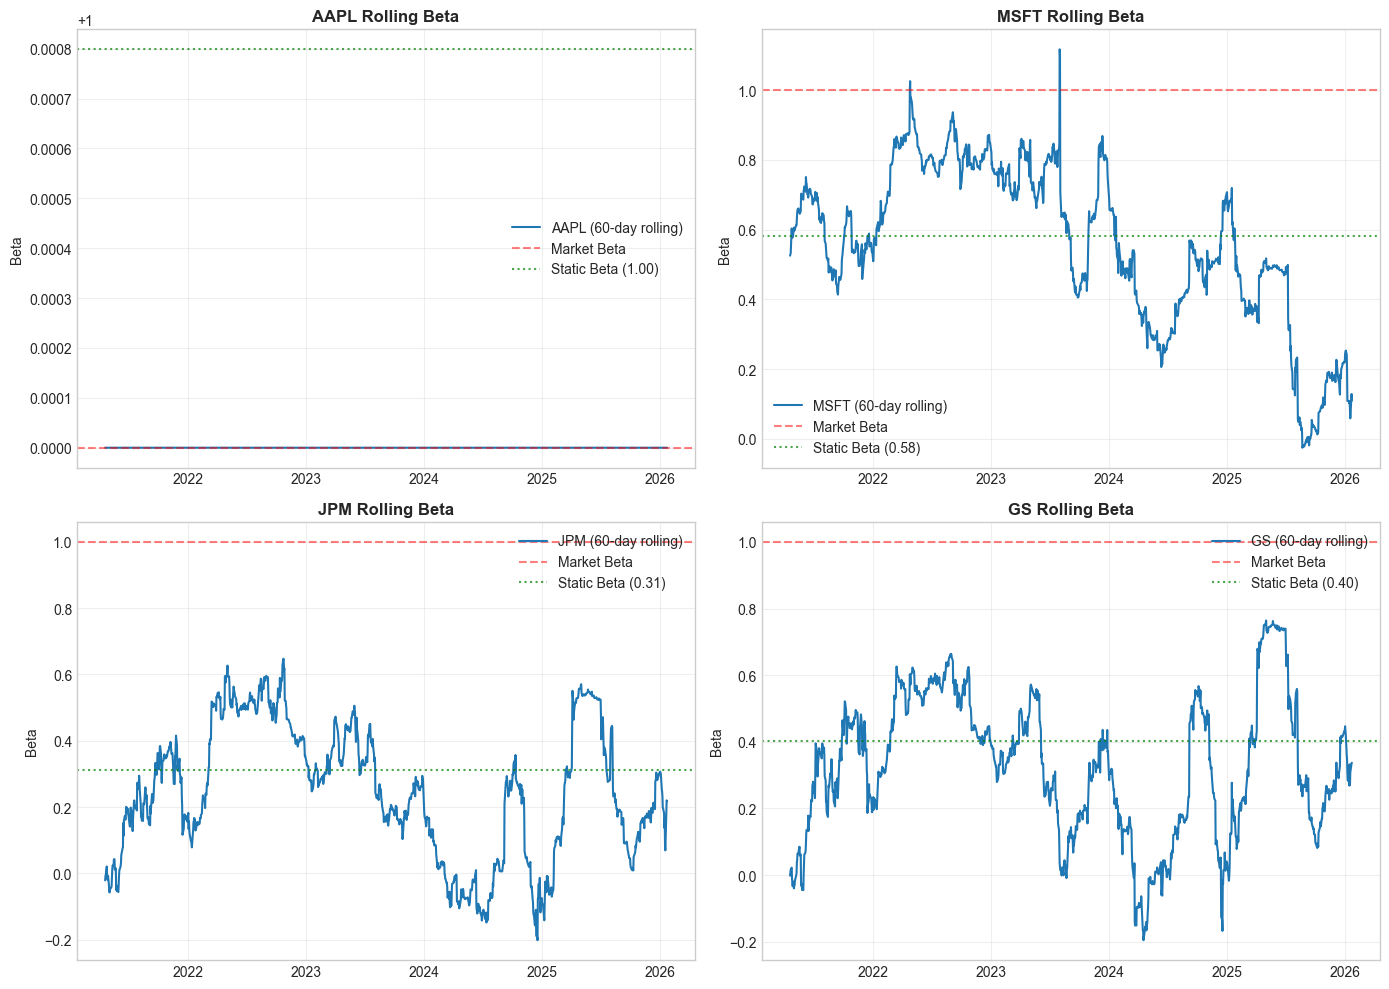


💡 Key Insight: Beta is NOT constant over time!
   - Betas tend to increase during market stress
   - Rolling beta captures changing risk relationships


In [5]:
def rolling_beta(stock_returns, market_returns, window=60):
    """Calculate rolling beta."""
    rolling_cov = stock_returns.rolling(window).cov(market_returns)
    rolling_var = market_returns.rolling(window).var()
    return rolling_cov / rolling_var

# Calculate rolling betas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, stock in enumerate(['AAPL', 'MSFT', 'JPM', 'GS']):
    if stock in returns.columns:
        rb = rolling_beta(returns[stock], market_returns, window=60)
        
        axes[i].plot(rb.index, rb.values, label=f'{stock} (60-day rolling)')
        axes[i].axhline(1, color='red', linestyle='--', alpha=0.5, label='Market Beta')
        
        # Add static beta
        static_beta = calculate_beta(returns[stock], market_returns)
        axes[i].axhline(static_beta, color='green', linestyle=':', alpha=0.7, 
                       label=f'Static Beta ({static_beta:.2f})')
        
        axes[i].set_title(f'{stock} Rolling Beta', fontweight='bold')
        axes[i].set_ylabel('Beta')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: Beta is NOT constant over time!")
print("   - Betas tend to increase during market stress")
print("   - Rolling beta captures changing risk relationships")

## 5. CAPM Limitations and Testing

In [6]:
print("="*60)
print("CAPM TESTING & LIMITATIONS")
print("="*60)

# Test: Is alpha significantly different from zero?
print("\n📊 Alpha Significance Tests:")
print(f"{'Stock':<8} {'Alpha':<12} {'t-stat':<10} {'p-value':<10} {'Significant?'}")
print("-"*60)

for stock in test_stocks:
    if stock in returns.columns:
        excess_stock = returns[stock] - daily_rf
        excess_market = market_returns - daily_rf
        
        X = sm.add_constant(excess_market)
        model = sm.OLS(excess_stock, X).fit()
        
        alpha = model.params.iloc[0] * TRADING_DAYS
        t_stat = model.tvalues.iloc[0]
        p_value = model.pvalues.iloc[0]
        significant = "Yes" if p_value < 0.05 else "No"
        
        print(f"{stock:<8} {alpha:<12.4%} {t_stat:<10.4f} {p_value:<10.4f} {significant}")

print("\n⚠️ CAPM Limitations:")
print("   1. Single-factor model may be insufficient")
print("   2. Beta is time-varying, not constant")
print("   3. Assumes investors only care about mean and variance")
print("   4. Market portfolio is unobservable (Roll's critique)")
print("   5. Anomalies: Size, value, momentum effects")

CAPM TESTING & LIMITATIONS

📊 Alpha Significance Tests:
Stock    Alpha        t-stat     p-value    Significant?
------------------------------------------------------------
AAPL     0.0000%      2.2186     0.0267     Yes
MSFT     6.3325%      0.7063     0.4801     No
GOOGL    18.2449%     1.6032     0.1091     No
JPM      13.8939%     1.3635     0.1730     No
GS       21.3398%     1.9083     0.0566     No

⚠️ CAPM Limitations:
   1. Single-factor model may be insufficient
   2. Beta is time-varying, not constant
   3. Assumes investors only care about mean and variance
   4. Market portfolio is unobservable (Roll's critique)
   5. Anomalies: Size, value, momentum effects


## Key Takeaways

1. **CAPM provides expected return** based on systematic risk (beta)
2. **Beta measures sensitivity** to market movements
3. **Alpha represents excess return** not explained by market exposure
4. **SML shows fair pricing** - above = undervalued, below = overvalued
5. **Beta varies over time** - use rolling analysis for dynamic risk

---
*Next: Day 2 - Fama-French 3-Factor Model*

## 🔴 PROS & CONS: CAPM

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [7]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - CAPM Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 15:11

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
